Import the libraries necessary to analize data

In [3]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

In [4]:
df = pd.read_csv('df_scaled.csv')

In [5]:
column_to_drop = ['n_participants','n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'total_votes_for_state', 'involve_killing', 'pc1', 'pc2']
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_participants_adult',
 'n_males',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'total_votes_for_state',
 'involve_killing',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [6]:
df_categorical = df[column_to_drop]
df_numeric = df.drop(columns=column_to_drop)

In [7]:
df_categorical.info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   n_participants             197914 non-null  float64
 1   n_participants_child       197914 non-null  int64  
 2   n_participants_teen        197914 non-null  int64  
 3   n_participants_adult       197914 non-null  int64  
 4   n_males                    197914 non-null  float64
 5   n_females                  197914 non-null  float64
 6   n_killed                   197914 non-null  float64
 7   n_injured                  197914 non-null  float64
 8   n_arrested                 197914 non-null  float64
 9   n_unharmed                 197914 non-null  float64
 10  date                       197914 non-null  object 
 11  latitude                   197914 non-null  float64
 12  longitude                  197914 non-null  float64
 13  congressional_district     19

# K-means

In [8]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score

Knee Method to estimate the best K

In [9]:
k_grid = [2, 3, 4, 10, 100, 1000]

sse_list = list()

label_list = []
dict_kmeans = {}
#search for the best k
for k in k_grid:

    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_numeric)
    
    sse = kmeans.inertia_
    labels = kmeans.labels_

    dict_kmeans[f'{k}_sse'] = sse
    dict_kmeans[f'{k}_labels'] = labels

" k_grid = [2, 3, 4, 10, 100, 1000]\n\nsse_list = list()\n\nlabel_list = []\ndict_kmeans = {}\n#search for the best k\nfor k in k_grid:\n\n    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)\n    kmeans.fit(df_numeric)\n    \n    sse = kmeans.inertia_\n    labels = kmeans.labels_\n\n    dict_kmeans[f'{k}_sse'] = sse\n    dict_kmeans[f'{k}_labels'] = labels "

In [10]:
for k in k_grid:
    print(f'for k = {k}')
    
    print('SSE %s' % dict_kmeans[f'{k}_sse']) # cohesion, lower value better clustering (error minimization)
    current_bouldin = metrics.davies_bouldin_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_bouldin_score'] = current_bouldin
    print('Separation %s' % current_bouldin) # lower value, better clustering (minimum zero)
    
    current_silhouette = silhouette_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_silhouette_score'] = current_silhouette
    print('Silhouette %s' % current_silhouette)

" for k in k_grid:\n    print(f'for k = {k}')\n    \n    print('SSE %s' % dict_kmeans[f'{k}_sse']) # cohesion, lower value better clustering (error minimization)\n    current_bouldin = metrics.davies_bouldin_score(df_numeric, dict_kmeans[f'{k}_labels'])\n    dict_kmeans[f'{k}_bouldin_score'] = current_bouldin\n    print('Separation %s' % current_bouldin) # lower value, better clustering (minimum zero)\n    \n    current_silhouette = silhouette_score(df_numeric, dict_kmeans[f'{k}_labels'])\n    dict_kmeans[f'{k}_silhouette_score'] = current_silhouette\n    print('Silhouette %s' % current_silhouette) "

In [11]:
sse_list = [dict_kmeans[f'{k}_sse'] for k in k_grid]
plt.plot(k_grid,sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

" sse_list = [dict_kmeans[f'{k}_sse'] for k in k_grid]\nplt.plot(k_grid,sse_list)\nplt.ylabel('SSE', fontsize=22)\nplt.xlabel('K', fontsize=22)\nplt.tick_params(axis='both', which='major', labelsize=22)\nplt.show() "

In [12]:
silhouette_list = [dict_kmeans[f'{k}_silhouette_score'] for k in k_grid]
plt.plot(k_grid, silhouette_list)
plt.ylabel('silhouette')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('SILHOUETTE SCORE')
#plt.axvline(6)
plt.show()

" silhouette_list = [dict_kmeans[f'{k}_silhouette_score'] for k in k_grid]\nplt.plot(k_grid, silhouette_list)\nplt.ylabel('silhouette')\nplt.xlabel('K')\nplt.tick_params(axis='both', which='major', labelsize=22)\nplt.title('SILHOUETTE SCORE')\n#plt.axvline(6)\nplt.show() "

From both elbow method and silhouette score, best K is around 4.

In [13]:
#RETRAIN BEST K-MEANS
best_k = 4
best_kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=100)
best_kmeans.fit(df_numeric)

KMeans(max_iter=100, n_clusters=4, n_init=10)

In [14]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(best_kmeans.labels_ == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [82594, 22099, 36298, 56923]


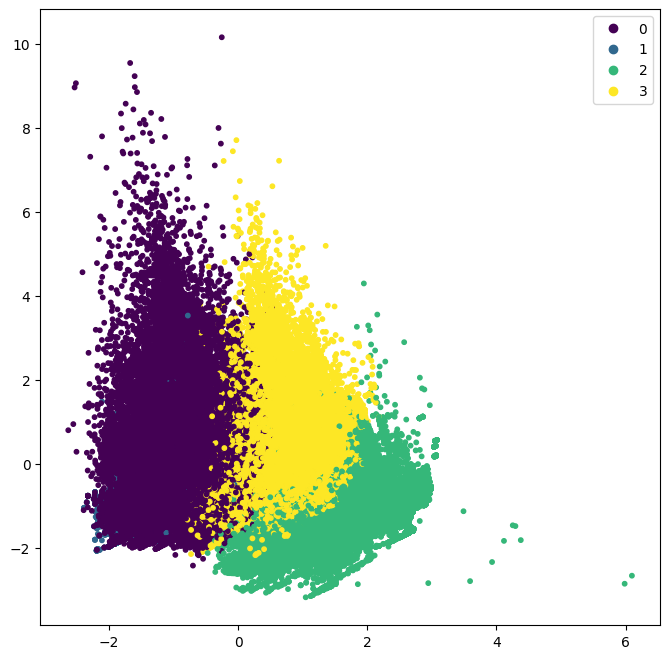

In [15]:
plt.figure(figsize=(8,8))
#printing the scatter without -1 labels (noise points)
scatter = plt.scatter(df['pc1'], df['pc2'], c=best_kmeans.labels_, s=10)
#scatter = plt.scatter(df['pc1'], df['pc2'], c=dbscan.labels_, s=10)

plt.tick_params(axis='both', which='major')
plt.legend(*scatter.legend_elements())

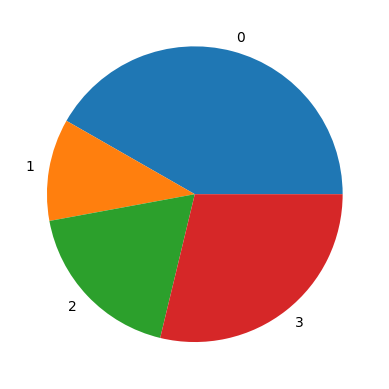

In [16]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

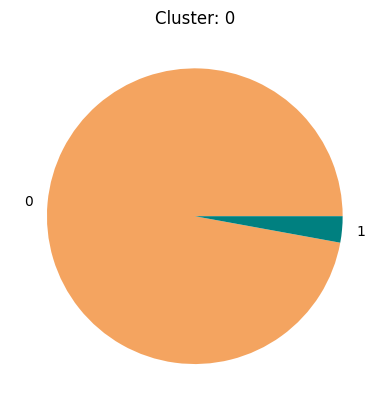

involve_killing
0    80225
1     2369
Name: count, dtype: int64


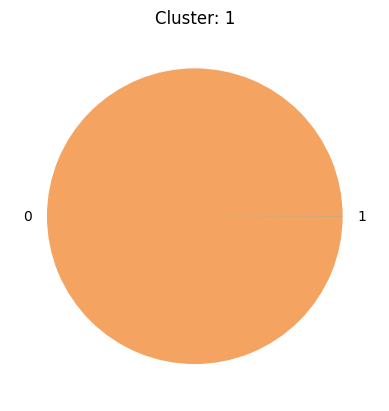

involve_killing
0    22095
1        4
Name: count, dtype: int64


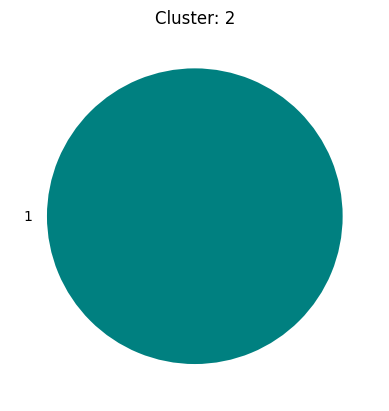

involve_killing
1    36298
Name: count, dtype: int64


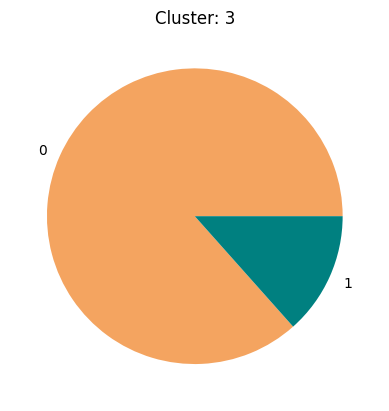

involve_killing
0    49283
1     7640
Name: count, dtype: int64


In [17]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}


for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[best_kmeans.labels_ == k].value_counts()
    # Show pie plot
    labels = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)

# X Means 
#### from: https://github.com/annoviko/pyclustering/

In [18]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [19]:
start_centroids = 7
start_clusters = kmeans_plusplus_initializer(df_numeric, start_centroids, random_state=42).initialize()
 
x_means = xmeans(df_numeric, start_clusters, tolerance=1e-6, kmax=20, repeat=10, random_state=42)
x_means.process()
 
# Clustering results:
print(f'Number of clusters found:', np.shape(x_means.get_centers())[0])
print("SSE:", x_means.get_total_wce())

Number of clusters found: 20
SSE: 348138.3096027993


In [ ]:
labels = {}
clusters = x_means.get_clusters()
n_clusters = np.shape(clusters)[0]
#transforming each cluster list from [[cluster1 m points], ...., [clustern p points]] to [[1,1,,....,1 m times], [n,....,n p times]] 
#to {point1:labelcluster1,...., pointm:labelcluster1, ....., point1:labelclustern, ...., pointp:labelclustern} sorted by number of example.
for cluster_label in range(0, n_clusters):
  for i in range(0, len(clusters[cluster_label])):
      labels[clusters[cluster_label][i]] = cluster_label

labels = dict(sorted(labels.items()))
xmeans_labels = list(labels.values())

In [21]:
print('Separation %s' % metrics.davies_bouldin_score(df_numeric, xmeans_labels)) # lower value, better clustering (minimum zero)
print('Silhouette %s' % silhouette_score(df_numeric, xmeans_labels))

Separation 1.3190759446189106
Silhouette 0.2228591532709577


In [26]:
# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(np.array(xmeans_labels) == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [3970, 4716, 9874, 3650, 10385, 3318, 8329, 1524, 22985, 13212, 7370, 11755, 8142, 7601, 6419, 4595, 14733, 19698, 21192, 14446]


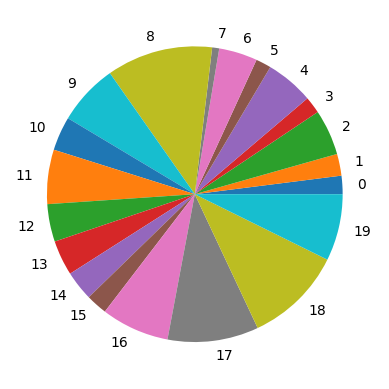

In [27]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show() 

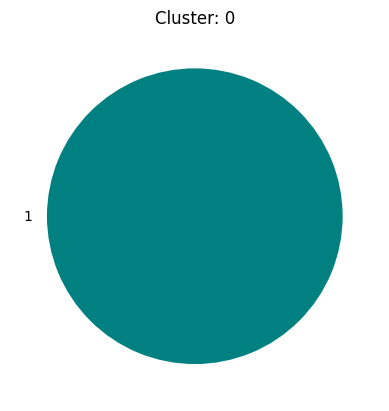

involve_killing
1    3970
Name: count, dtype: int64


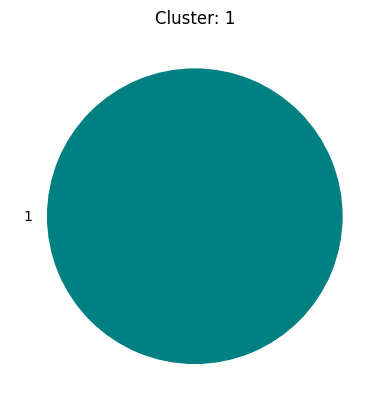

involve_killing
1    4716
Name: count, dtype: int64


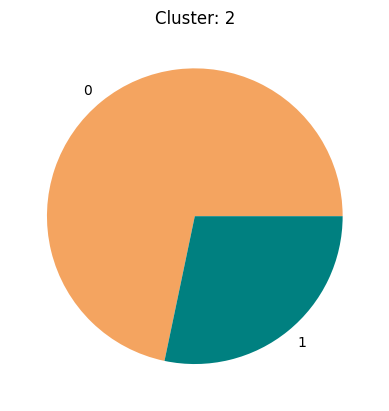

involve_killing
0    7081
1    2793
Name: count, dtype: int64


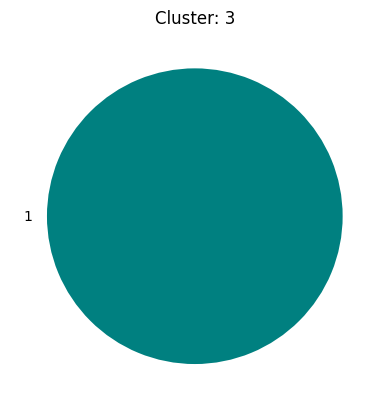

involve_killing
1    3650
Name: count, dtype: int64


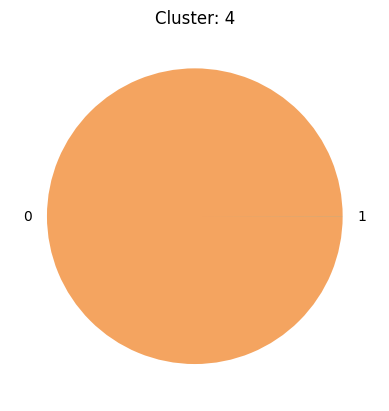

involve_killing
0    10384
1        1
Name: count, dtype: int64


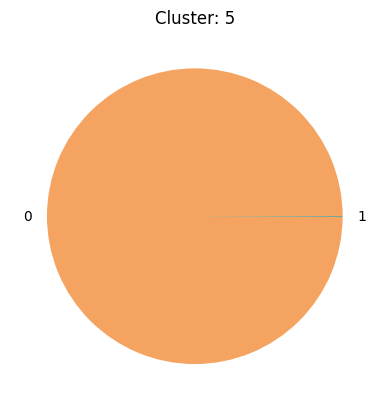

involve_killing
0    3316
1       2
Name: count, dtype: int64


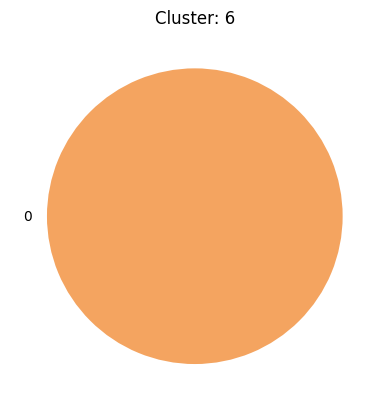

involve_killing
0    8329
Name: count, dtype: int64


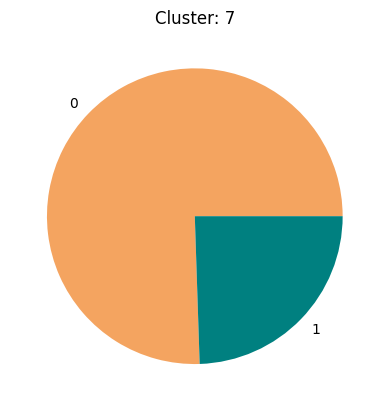

involve_killing
0    1151
1     373
Name: count, dtype: int64


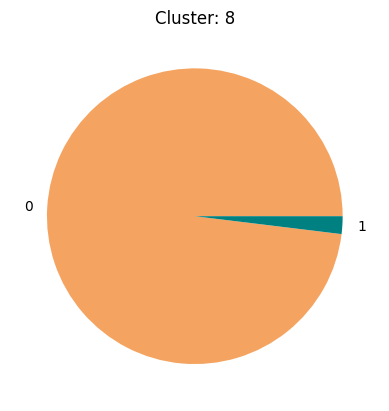

involve_killing
0    22541
1      444
Name: count, dtype: int64


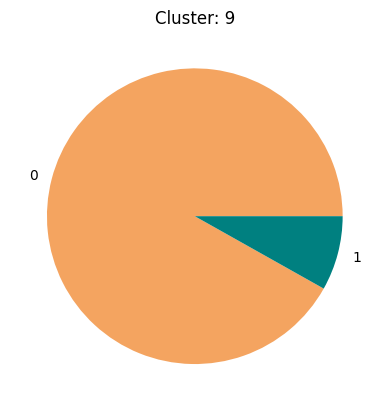

involve_killing
0    12136
1     1076
Name: count, dtype: int64


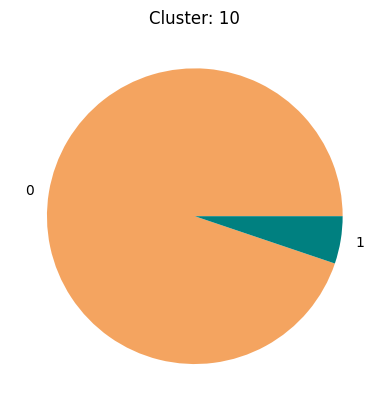

involve_killing
0    6988
1     382
Name: count, dtype: int64


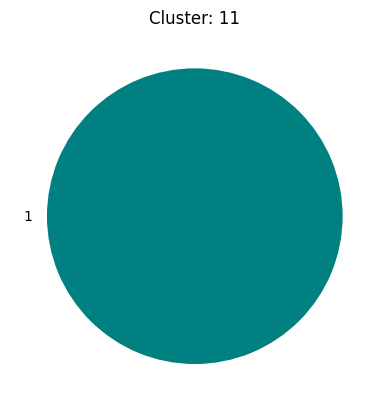

involve_killing
1    11755
Name: count, dtype: int64


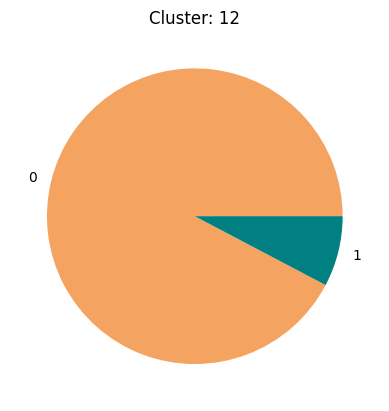

involve_killing
0    7514
1     628
Name: count, dtype: int64


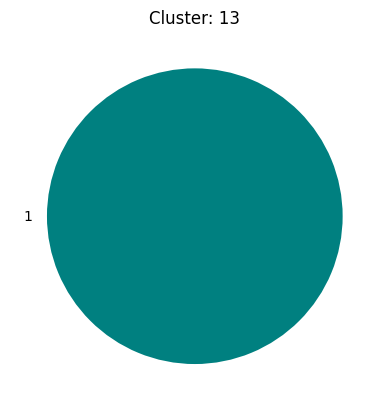

involve_killing
1    7601
Name: count, dtype: int64


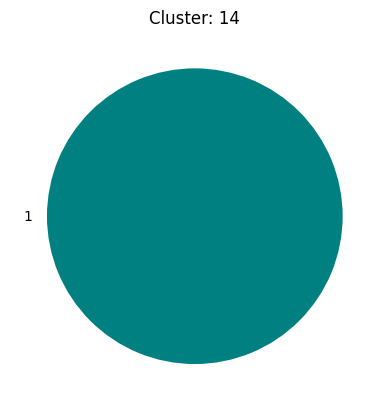

involve_killing
1    6419
Name: count, dtype: int64


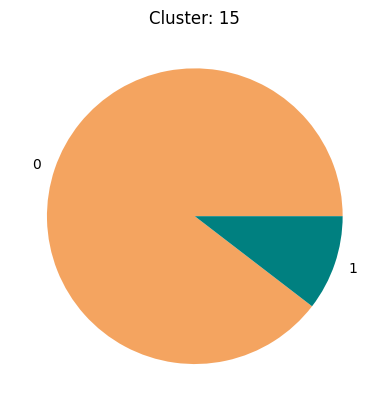

involve_killing
0    4116
1     479
Name: count, dtype: int64


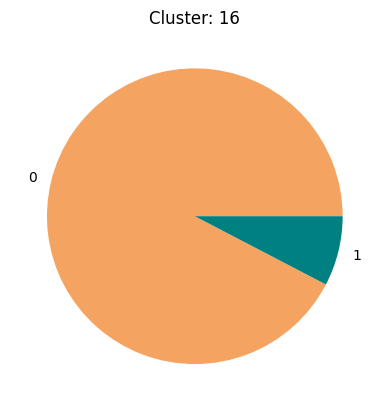

involve_killing
0    13607
1     1126
Name: count, dtype: int64


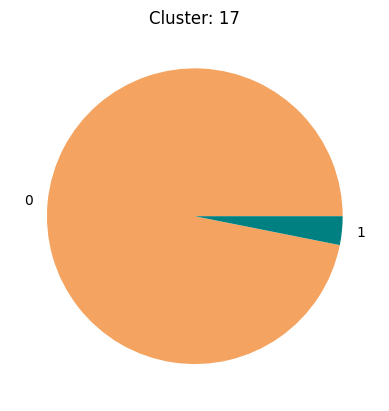

involve_killing
0    19081
1      617
Name: count, dtype: int64


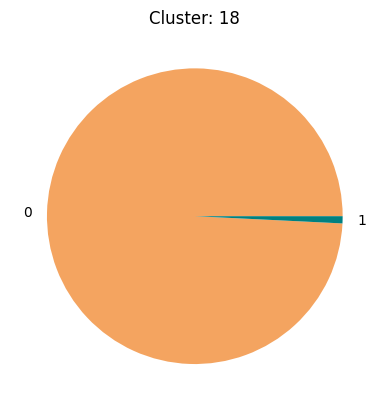

involve_killing
0    21027
1      165
Name: count, dtype: int64


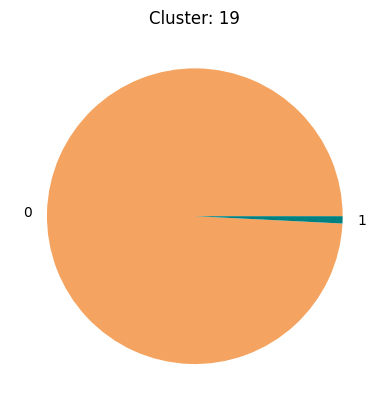

involve_killing
0    14332
1      114
Name: count, dtype: int64


In [29]:
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}

for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[np.array(xmeans_labels) == k].value_counts()
    # Show pie plot
    labels = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)